In [53]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target

In [54]:
data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [55]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [56]:
target

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

In [57]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [58]:
target *= 100 #  transform the prices from the 100 (k$) range to the thousand dollars
target.head()

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

To solve this regression task, we will use a decision tree regressor.

In [59]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(data, target)

DecisionTreeRegressor(random_state=0)

In [60]:
data.shape

(20640, 8)

After training the regressor, we would like to know its potential generalization performance once deployed in production. For this purpose, we use the mean absolute error, which gives us an error in the native unit, i.e. k$.

In [61]:
from sklearn.metrics import mean_absolute_error

target_predicted = regressor.predict(data)
score = mean_absolute_error(target, target_predicted)
print(f"On average, our regressor makes an error of {score:.2f} k$")

On average, our regressor makes an error of 0.00 k$


We get perfect prediction with no error. It is too optimistic and almost always revealing a methodological problem when doing machine learning.

Since our decision tree was fully grown, every sample in the dataset is stored in a leaf node. Therefore, our decision tree fully memorized the dataset given during fit and therefore made no error when predicting.

This error computed above is called the **empirical error or training error**

We trained a predictive model to minimize the training error but our aim is to minimize the error on data that has not been seen during training.

This error is also called the **generalization error** or the “true” testing error

In [62]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(data, target, random_state=0)
regressor.fit(data_train, target_train)

DecisionTreeRegressor(random_state=0)

In [63]:
target_predicted = regressor.predict(data_train)
score = mean_absolute_error(target_train, target_predicted)
print(f"The training error of our model is {score:.2f} k$")

The training error of our model is 0.00 k$


we now compute the testing error.

In [64]:
target_predicted = regressor.predict(data_test)
score = mean_absolute_error(target_test, target_predicted)
print(f"The testing error of our model is {score:.2f} k$")

The testing error of our model is 47.28 k$


testing error is actually about what we would expect from our model if it was used in a production environment

**Cross-validation** allows estimating the robustness of a predictive model by repeating the splitting procedure. It will give several training and testing errors and thus some **estimate of the variability of the model generalization performance**.

There are different <a href="https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators" target="blank">cross-validation strategies</a>, for now we are going to focus on one called “`shuffle-split`”. At each iteration of this strategy we:

randomly shuffle the order of the samples of a copy of the full dataset;

split the shuffled dataset into a train and a test set;

train a new model on the train set;

evaluate the testing error on the test set.

We repeat this procedure `n_splits` times. Keep in mind that the computational cost increases with `n_splits`.

<img src="https://inria.github.io/scikit-learn-mooc/_images/shufflesplit_diagram.png" />

To evaluate the generalization performance of our regressor, we can use `sklearn.model_selection.cross_validate` with a `sklearn.model_selection.ShuffleSplit` object

In [65]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
regressor = DecisionTreeRegressor(random_state=0)
cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
cv_results = cross_validate(
    regressor, data, target, cv=cv, scoring="neg_mean_absolute_error"
)

The results `cv_results` are stored into a Python dictionary. We will convert it into a pandas dataframe to ease visualization and manipulation.

In [66]:
import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results.head()

,fit_time,score_time,test_score
0,0.228817,0.003999,-46.909797
1,0.240475,0.003002,-46.421170
2,0.232962,0.003519,-47.411089
3,0.215432,0.002997,-44.319824
4,0.211381,0.003001,-47.607875


**A score is a metric for which higher values mean better results. On the contrary, an error is a metric for which lower values mean better results. The parameter scoring in cross_validate always expect a function that is a score.**

To make it easy, all error metrics in scikit-learn, like `mean_absolute_error`, can be transformed into a score to be used in `cross_validate`. To do so, you need to pass a string of the error metric with an additional `neg_` string at the front to the parameter `scoring`; for instance `scoring="neg_mean_absolute_error"`. In this case, the negative of the mean absolute error will be computed which would be equivalent to a score.

In [67]:
cv_results["test_error"] = -cv_results["test_score"]

In [68]:
cv_results.head(10)

,fit_time,score_time,test_score,test_error
0,0.228817,0.003999,-46.909797,46.909797
1,0.240475,0.003002,-46.421170,46.421170
2,0.232962,0.003519,-47.411089,47.411089
3,0.215432,0.002997,-44.319824,44.319824
4,0.211381,0.003001,-47.607875,47.607875
5,0.215112,0.003008,-45.901300,45.901300
6,0.214551,0.003001,-46.572767,46.572767
7,0.211700,0.003001,-46.194585,46.194585
8,0.211697,0.003370,-45.590236,45.590236
9,0.213350,0.002999,-45.727998,45.727998


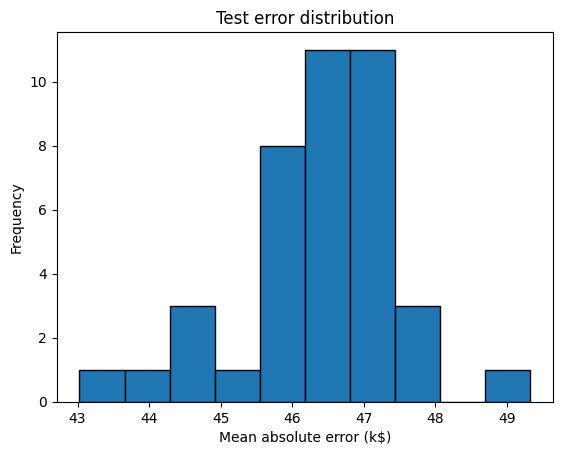

In [69]:
import matplotlib.pyplot as plt

cv_results["test_error"].plot.hist(bins=10, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Test error distribution")

In [70]:
print(
    "The mean cross-validated testing error is: "
    f"{cv_results['test_error'].mean():.2f} k$"
)

The mean cross-validated testing error is: 46.36 k$


In [71]:
print(
    "The standard deviation of the testing error is: "
    f"{cv_results['test_error'].std():.2f} k$"
)

The standard deviation of the testing error is: 1.17 k$


**Note that the standard deviation is much smaller than the mean: we could summarize that our cross-validation estimate of the testing error is 46.36 ± 1.17 k$.**

 plot the distribution of the target variable

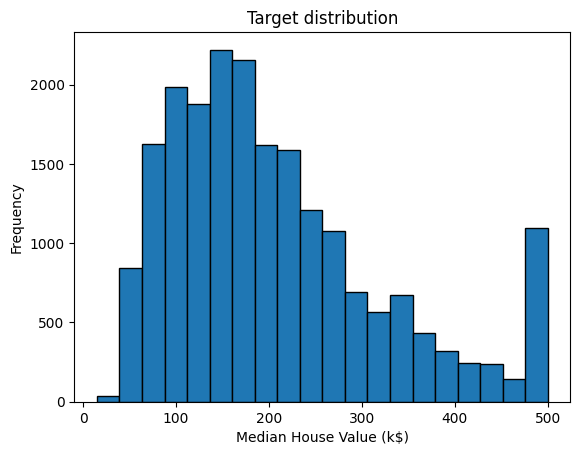

In [72]:
target.plot.hist(bins=20, edgecolor="black")
plt.xlabel("Median House Value (k$)")
_ = plt.title("Target distribution")

In [73]:
print(f"The standard deviation of the target is: {target.std():.2f} k$")

The standard deviation of the target is: 115.40 k$


The target variable ranges from close to 0 k$ up to 500 k$ and, with a standard deviation around 115 k$.

notice that the mean estimate of the testing error obtained by cross-validation is a bit smaller than the natural scale of variation of the target variable. Furthermore, the standard deviation of the cross validation estimate of the testing error is even smaller.

our model makes, on average, an error around 47 k$. With this information and looking at the target distribution, such an error might be acceptable when predicting houses with a 500 k$. However, it would be an issue with a house with a value of 50 k$. Thus, this indicates that our metric (Mean Absolute Error) is not ideal.

In [74]:
cv_results = cross_validate(regressor, data, target, return_estimator=True)
cv_results

{'fit_time': array([0.29789138, 0.28834677, 0.26583624, 0.25305152, 0.24337292]),
 'score_time': array([0.00309563, 0.00300336, 0.00300002, 0.00200057, 0.00199962]),
 'estimator': [DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0)],
 'test_score': array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361])}

The five decision tree regressors corresponds to the five fitted decision trees on the different folds. Having access to these regressors is handy because it allows to inspect the internal fitted parameters of these regressors.

only test score

In [75]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(regressor, data, target)
scores

array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361])

# Overfit-generalization-underfit

In [76]:
housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
target *= 100  # rescale the target in k$
regressor = DecisionTreeRegressor()

To better understand the generalization performance of our model and maybe find insights on how to improve it, we will compare the testing error with the training error. Thus, we need to compute the error on the training set, which is possible using the `cross_validate` function.

In [77]:
import pandas as pd
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2)
cv_results = cross_validate(
    regressor,
    data,
    target,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    n_jobs=-1,
)
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_score,train_score
0,0.472035,0.004001,-45.511768,-3.194688e-15
1,0.497003,0.003516,-45.293328,-1.016241e-14
2,0.540576,0.010530,-47.441706,-3.724841e-15
3,0.522617,0.004517,-46.999416,-1.454478e-14
4,0.424802,0.005518,-43.761739,-1.531247e-14
5,0.592154,0.004510,-47.115228,-1.527030e-14
6,0.599665,0.005513,-46.538534,-1.531247e-14
7,0.493954,0.005508,-46.729403,-3.435667e-15
8,0.417805,0.004004,-46.560703,-1.591836e-14
9,0.555642,0.005001,-44.278817,-3.504518e-15


cross-validation uses the negative mean absolute error. We transform the negative mean absolute error into a positive mean absolute error.

In [78]:
scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[
    ["train_score", "test_score"]
]

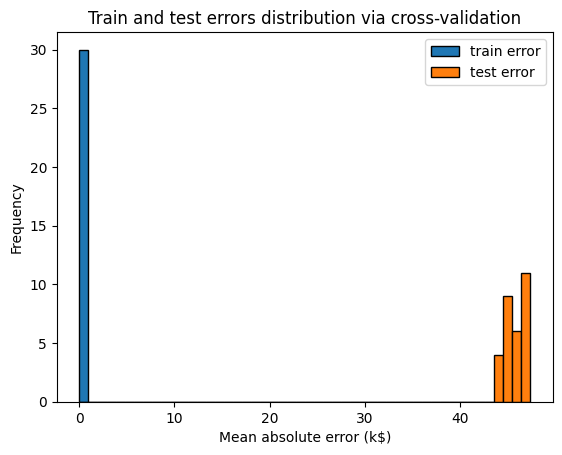

In [79]:
scores.plot.hist(bins=50, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Train and test errors distribution via cross-validation")

By plotting the distribution of the training and testing errors, we get information about whether our model is over-fitting, under-fitting (or both at the same time).

Here, we observe a **small training error** (actually zero), meaning that the model is not under-fitting: it is flexible enough to capture any variations present in the training set.

However the significantly **larger testing error** tells us that the **model is over-fitting**: the model has memorized many variations of the training set that could be considered “noisy” because they do not generalize to help us make good prediction on the test set.

# Validation curve

Some `model hyperparameters` are usually the key to go from a model that underfits to a model that overfits, hopefully going through a region were we can get a good balance between the two. We can acquire knowledge by plotting a curve called the validation curve. This curve can also be applied to the above experiment and varies the value of a hyperparameter.

For the decision tree, the `max_depth` parameter is used to control the tradeoff between under-fitting and over-fitting.

In [80]:
DecisionTreeRegressor?

Init signature:
DecisionTreeRegressor(
    *,
    criterion='squared_error',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    ccp_alpha=0.0,
)
Docstring:     
A decision tree regressor.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"squared_error", "friedman_mse", "absolute_error",             "poisson"}, default="squared_error"
    The function to measure the quality of a split. Supported criteria
    are "squared_error" for the mean squared error, which is equal to
    variance reduction as feature selection criterion and minimizes the L2
    loss using the mean of each terminal node, "friedman_mse", which uses
    mean squared error with Friedman's improvement score for potential
    splits, "absolute_error" for the mean absolute error, which minimizes
    the L1 loss usi

In [81]:
%%time
from sklearn.model_selection import validation_curve

max_depth = [1, 5, 10, 15, 20, 25]
train_scores, test_scores = validation_curve(
    regressor,
    data,
    target,
    param_name="max_depth",
    param_range=max_depth,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
)
train_errors, test_errors = -train_scores, -test_scores

CPU times: total: 109 ms
Wall time: 17.6 s


In [82]:
train_errors.mean(axis=1)

array([74.42141238, 50.90567047, 31.91704307, 12.18321843,  2.22700774,
        0.19183038])

Now that we collected the results, we will show the validation curve by plotting the training and testing errors (as well as their deviations).

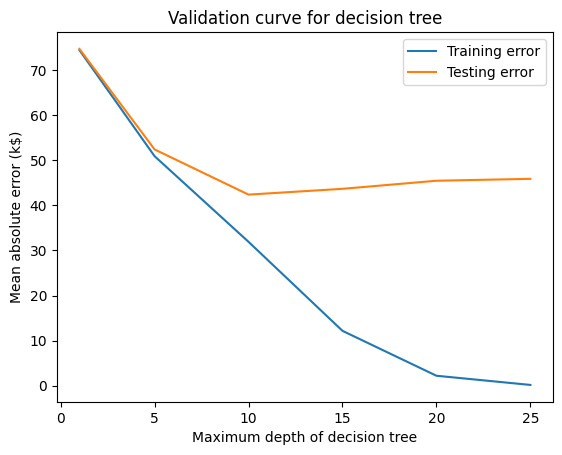

In [83]:
plt.plot(max_depth, train_errors.mean(axis=1), label="Training error")
plt.plot(max_depth, test_errors.mean(axis=1), label="Testing error")
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for decision tree")

The validation curve can be divided into three areas:
- For `max_depth < 10`, the decision tree underfits. The training error and therefore the testing error are both high. The model is too constrained and cannot capture much of the variability of the target variable.

- The region around `max_depth = 10` corresponds to the parameter for which the decision tree generalizes the best. It is flexible enough to capture a fraction of the variability of the target that generalizes, while not memorizing all of the noise in the target.

- For `max_depth > 10`, the decision tree overfits. The training error becomes very small, while the testing error increases. In this region, the models create decisions specifically for noisy samples harming its ability to generalize to test data.


Note that for `max_depth = 10`, the model overfits a bit as there is a gap between the training error and the testing error. It can also potentially underfit also a bit at the same time, because the training error is still far from zero (more than 30 k$), meaning that the model might still be too constrained to model interesting parts of the data. 

However, the **testing error is minimal**, and this is what really matters. This is the best compromise we could reach by just tuning this parameter

We should also look at the standard deviation to assess the dispersion of the score. We can repeat the same plot as before but this time, we will add some information to show the standard deviation of the errors as well.

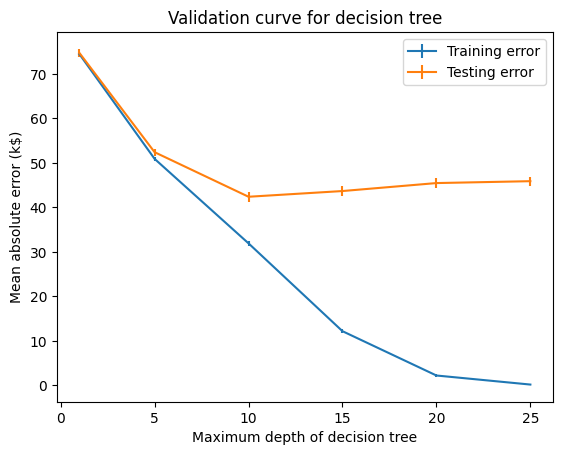

In [84]:
plt.errorbar(
    max_depth,
    train_errors.mean(axis=1),
    yerr=train_errors.std(axis=1),
    label="Training error",
)
plt.errorbar(
    max_depth,
    test_errors.mean(axis=1),
    yerr=test_errors.std(axis=1),
    label="Testing error",
)
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for decision tree")

# Effect of the sample size in cross-validation

understand how the different errors are influenced by the number of samples available.

## Learning curve
To understand the impact of the number of samples available for training on the generalization performance of a predictive model, it is possible to synthetically reduce the number of samples used to train the predictive model and check the training and testing errors.

The training and testing scores can be plotted similarly to the validation curve, but instead of varying a hyperparameter, we vary the number of training samples. This curve is called the **learning curve.**

Let’s compute the learning curve for a decision tree and vary the proportion of the training set from 10% to 100%.

In [85]:
import numpy as np

train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)
train_sizes

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

In [86]:
cv = ShuffleSplit(n_splits=30, test_size=0.2)

c:\Users\ZAID\miniconda3\lib\site-packages\sklearn\model_selection\_plot.py:113: FutureWarning: The `log_scale` parameter is deprecated as of version 1.3 and will be removed in 1.5. You can use display.ax_.set_xscale and display.ax_.set_yscale instead.
  warnings.warn(


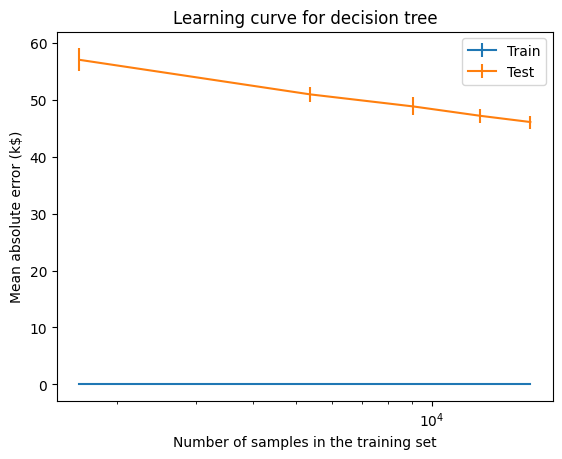

In [87]:
from sklearn.model_selection import LearningCurveDisplay

display = LearningCurveDisplay.from_estimator(
    regressor,
    data,
    target,
    train_sizes=train_sizes,
    cv=cv,
    score_type="both",  # both train and test errors
    scoring="neg_mean_absolute_error",
    negate_score=True,  # to use when metric starts with "neg_"
    log_scale=True,  # sets log scale for the x-axis
    score_name="Mean absolute error (k$)",
    std_display_style="errorbar",
    n_jobs=2,
)
_ = display.ax_.set_title("Learning curve for decision tree")

Looking at the training error alone, we see that we get an error of 0 k$. It means that the trained model (i.e. decision tree) is clearly overfitting the training data.

Looking at the testing error alone, we observe that the more samples are added into the training set, the lower the testing error becomes. Also, we are searching for the plateau of the testing error for which there is no benefit to adding samples anymore or assessing the potential gain of adding more samples into the training set.

If we achieve a plateau and adding new samples in the training set does not reduce the testing error, we might have reached the *Bayes error rate* using the available model. Using a more complex model might be the only possibility to reduce the testing error further.

### Summary
In this notebook you learned:
- how to identify whether a model is generalizing, overfitting, or underfitting;

- how to check influence of a hyperparameter on the tradeoff underfit/overfit.

- the influence of the number of samples in a dataset, especially on the variability of the errors reported when running the cross-validation;

- about the learning curve, which is a visual representation of the capacity of a model to improve by adding new samples.